# Data analysis of skeletal muscle area and SMI for normal patients

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [2]:
# from IPython import get_ipython
from IPython.display import display, HTML
#from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [3]:
# Install statsmodels if it doesn't exist
import pip
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
packages = ['statsmodels','matplotlib','scipy','pygrowup','sklearn']

for package in packages:
    import_or_install(package)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-k_dod30q because the default path (/home/jupyteruser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [5]:
cwd = os.getcwd()
print(cwd)

/home/jupyteruser/smipipeline


In [6]:
data = '/home/jupyteruser/data'
pickles = '/home/jupyteruser/pickles'
models = '/home/jupyteruser/models'
output = '/home/jupyteruser/output/results'

In [7]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction_CV_poorl3.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'l3_finder': {'cache_dir': '/tf/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/tf/data',
               'model_path_dir': '/tf/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/tf/output/cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/tf/models/muscle/cv_final',
                      'output_directory': '/tf/output/cv_poorl3/ms'}}


In [8]:
for key in config.keys():
    for label, value in config[key].items():
        if type(value) is str:
            config[key][label] = value.replace('/tf', '/home/jupyteruser')

pp.pprint(config)

{'l3_finder': {'cache_dir': '/home/jupyteruser/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/home/jupyteruser/data',
               'model_path_dir': '/home/jupyteruser/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/home/jupyteruser/output/cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/home/jupyteruser/models/muscle/cv_final',
                      'output_directory': '/home/jupyteruser/output/cv_poorl3/ms'}}


## Produce data for analysis using prediction results and preprocessing results

In [9]:
# Load the area csv
filename = 'areas-mm2_by_subject_id_manualarea_for_outliers.csv'
#filename = 'areas-mm2_by_subject_id.csv'


sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],filename)
df_sma = pd.read_csv(sma_csv, index_col=False)

In [10]:
if 'outliers' in filename: # MOdified area sheet with manual area calculated for outlier patients
    display(df_sma.head(10))
    df_sma_manuals = df_sma.loc[~df_sma['area_mm2_Elan'].isnull()]
    for i,row in df_sma_manuals.iterrows():
        df_sma.loc[df_sma['subject_id']==row['subject_id'],'area_mm2'] = row['area_mm2_Elan']
    

# Manually identified diseases cases [by Andrew]:
man_disease = ['Z832424','Z1256768']

df_sma= df_sma.loc[~df_sma['subject_id'].isin(man_disease)]
df_sma = df_sma[['subject_id','area_mm2','sagittal_series','axial_series']]
print('Final patients for analysis: ',len(df_sma))

,subject_id,area_mm2,% auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
0,Z862651,15337.387500,NaN,NaN,NaN,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0
1,Z1310189,5194.947664,NaN,NaN,NaN,recon from: Z1310189-SE-4-Std_Axial_Body_Std_5.0,Z1310189-SE-4-Std_Axial_Body_Std_5.0
2,Z1452514,10329.928960,NaN,NaN,NaN,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0
3,Z1178360,7812.500000,NaN,NaN,NaN,recon from: Z1178360-SE-4-Body_5.0_CE,Z1178360-SE-4-Body_5.0_CE
4,Z1244498,4626.782208,NaN,NaN,NaN,Z1244498-SE-7-Bone_Sagittal_3.000,Z1244498-SE-2-Body_5.0
5,Z514679,15866.068320,NaN,NaN,NaN,Z514679-SE-11-Bone_Sagittal_3.000,Z514679-SE-5-Body__5.0
6,Z617099,10991.944600,NaN,NaN,NaN,recon from: Z617099-SE-3-Body,Z617099-SE-3-Body
7,Z437139,9915.643712,NaN,NaN,NaN,recon from: Z437139-SE-3-Pediatric_Std_5.0,Z437139-SE-3-Pediatric_Std_5.0
8,Z597267,6663.738276,NaN,NaN,NaN,recon from: Z597267-SE-4-Std_Axial_Body_Std_5.0,Z597267-SE-4-Std_Axial_Body_Std_5.0
9,Z1106026,6036.252768,NaN,NaN,NaN,Z1106026-SE-5-Sagittal_Body,Z1106026-SE-1002-Body_Clarity


Final patients for analysis:  1362


In [11]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
#display(df_sma.head(2))

In [12]:
# Load the df_final pickle
df_final_d1 = load_object(os.path.join(pickles,'df_final_dump1_processed.pkl'))
#print('dump 1 length = ',len(df_final_d1))
df_final_d2 = load_object(os.path.join(pickles,'df_final_dump2_processed.pkl'))
#print('dump 2 length = ',len(df_final_d2))

In [13]:
# Merge the  2 dumps
df_final = df_final_d1.append(df_final_d2)
print('Total processed final length (iteration 1, more patients were filtered in iteration 2 (more search terms)) = ',len(df_final))

Total processed final length (iteration 1, more patients were filtered in iteration 2 (more search terms)) =  2367


In [14]:
# Create the dataframe for analysis by merging df_sma with df_final
# Replace axial and sagittal series in df_final with df_sma that has 
# pointers to reconstructed sagittals, preserve the other fields.
df_final = df_final.drop(columns=['Axial','Sagittal'])
#display(df_final.head(10))

In [15]:
# Make sure both dfs are equal length
#print('Sma len: ', len(df_sma))
#print('Final len: ', len(df_final))

In [15]:
# 25 cases failed because of L3 level was out of bound, get rid of those for now:
df_final = df_final[df_final['ID'].isin(df_sma['ID'].values)]
print('No of patients processed successfully: ', len(df_final))

No of patients processed successfully:  1362


In [16]:
# Now merge on ID
df_analysis = pd.merge(df_sma,df_final, on="ID")
#display(df_analysis.head(10))

In [17]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI_corrected_v2.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
#display(df_P.head(10))

In [18]:
# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]
print("Total number of normal patients with images", len(df_P))

Total number of normal patients identified 1392
Total number of normal patients with images 1362


In [19]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

print('Length of final analysis df: ', len(df_analysis))

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

Length of final analysis df:  1362


In [23]:
# Manual L3 check
infile  = 'poorl3.csv'
df_poorl3 = pd.read_csv(infile, index_col=False)

l3_present = df_poorl3.loc[~df_poorl3['L3slice'].isnull(),'ID'].values.tolist()
print('Cases with manually identified L3s: ', len(l3_present))

Cases with manually identified L3s:  30


In [24]:
# This was used to filter exams for prediction in run_prediction_cv
# normal_patients_corrected = df_analysis.ID.values.tolist()
# print(len(normal_patients_corrected))
# save_object(normal_patients_corrected,os.path.join(pickles,'normal_patients_corrected.pkl'))

In [25]:
l3_present_analysis = [l3 for l3 in l3_present if l3 in df_analysis.ID.values]
print('Normal L3s that are valid: ', len(l3_present_analysis))
for l3 in l3_present_analysis:
    print(l3)

Normal L3s that are valid:  16
Z418856
Z357478
Z670302
Z1029886
Z1302641
Z627309
Z1722108
Z5745
Z489517
Z1332420
Z1263347
Z486791
Z320930
Z1221549
Z1274627
Z1119985


In [26]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 152
Patients missing BMI age percentile: 0
Patients missing Height: 15
Patients missing Weight 29
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [27]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [28]:
# Patients > 18
print('No of Patients > 18 years that are discarded' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years that are discarded 1


In [29]:
#print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
#print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

In [30]:
# Create sex stratified and age filtered dfs

df_analysis['area_cm2'] = df_analysis['area_mm2']/100


df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  666
Length of female df =  695


In [31]:
674/699

0.9642346208869814

## Population statistics in comparison to CDC/WHO data

In [32]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','Age_IQR','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        q75, q25 = np.percentile(df_l['Age'], [75 ,25])
        age_iqr = q75 - q25
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,age_iqr,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [33]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)
df_m_agestats.to_csv(output+'/Male_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


,AgeGroup_F,Age_IQR_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,Age_IQR_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,0.000000,14.640480,39.345553,1,0.0,0.626472,19.765578,52.728610,4
0,1.0,0.455484,29.197116,41.796652,3,1.0,0.000251,32.781918,47.632223,2
0,2.0,0.428267,32.976198,39.966734,13,2.0,0.484531,34.897644,41.780362,20
0,3.0,0.253105,38.898695,38.597684,10,3.0,0.397020,39.956490,40.795016,23
0,4.0,0.197646,36.271138,35.265092,10,4.0,0.427749,46.676156,38.838462,25
0,5.0,0.492027,47.491601,37.241887,12,5.0,0.479479,49.485522,38.228499,34
0,6.0,0.364520,46.258039,32.809869,28,6.0,0.456054,51.296368,37.048667,32
0,7.0,0.503201,51.041177,32.358297,27,7.0,0.585376,58.223413,36.757267,40
0,8.0,0.519758,55.980416,33.016537,30,8.0,0.485649,61.582427,35.099803,33
0,9.0,0.590334,62.074857,33.034537,34,9.0,0.453900,70.679467,35.741694,28


### Since n for age = 0 and 1 are less than 10, process only ages 2 and above.

In [34]:
print('NO of Females before filtering pats < 2yrs: ', len(df_f))
print('NO of Males before filtering pats < 2yrs: ', len(df_m))

NO of Females before filtering pats < 2yrs:  695
NO of Males before filtering pats < 2yrs:  666


In [35]:
df_f = df_f[df_f['Age'] >= 2]
df_m = df_m[df_m['Age'] >= 2]     

In [36]:
print('NO of Females after filtering pats < 2yrs: ', len(df_f))
print('NO of Males after filtering pats < 2yrs: ', len(df_m))

NO of Females after filtering pats < 2yrs:  691
NO of Males after filtering pats < 2yrs:  660


### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [33]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [34]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [35]:
df_f = df_f.apply(add_Z_scores,axis=1)
df_f = df_f.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_f = df_f.apply(add_Zpercentile_scores,axis=1)

In [36]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['BMI_CALC','WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [37]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
df_f_stats = calculate_stats(df_f).T.round(decimals=2)

In [38]:
print("Population Statistics for Male")
display(df_m_stats.head(12))
df_f_stats.to_csv(output+'/Female_summary_statistics.csv',index=True)
df_m_stats.to_csv(output+'/Male_summary_statistics.csv',index=True)

Population Statistics for Male


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,569.0,18.87,3.25,13.59,16.33,18.32,21.00,31.02
WEIGHT,641.0,44.48,20.41,11.00,26.70,41.30,60.50,99.00
HEIGHT,654.0,147.71,26.88,82.00,127.12,150.00,170.50,205.74
Age,660.0,11.36,4.41,2.00,7.79,11.99,15.12,18.78
area_cm2,660.0,91.70,39.51,22.51,58.86,83.50,122.29,207.83
smi,654.0,40.04,6.71,15.51,35.45,39.33,44.14,66.63
height_age_Zscore,654.0,0.30,1.17,-5.62,-0.41,0.34,1.02,4.26
height_age_Zpercentile,654.0,58.45,29.99,0.00,34.18,63.50,84.55,100.00
weight_age_Zscore,641.0,0.34,0.96,-7.34,-0.25,0.41,1.04,2.43
weight_age_Zpercentile,641.0,61.01,27.56,0.00,40.13,65.91,85.08,99.25


In [39]:
print("Population Statistics for Female")
display(df_f_stats.head(12))

Population Statistics for Female


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,631.0,20.45,3.79,13.13,17.38,20.19,23.14,29.61
WEIGHT,681.0,48.69,17.32,8.60,35.10,51.30,62.20,89.00
HEIGHT,683.0,150.34,20.17,74.00,141.00,157.00,164.55,191.00
Age,691.0,12.93,4.00,2.05,10.28,13.93,16.00,18.94
area_cm2,691.0,83.32,24.68,22.81,64.55,86.73,102.38,146.42
smi,683.0,36.19,5.75,13.00,32.65,35.68,39.88,77.72
height_age_Zscore,683.0,0.11,1.16,-7.65,-0.58,0.12,0.82,5.00
height_age_Zpercentile,683.0,53.65,30.00,0.00,27.93,54.78,79.25,100.00
weight_age_Zscore,681.0,0.39,0.91,-3.91,-0.14,0.51,1.05,2.37
weight_age_Zpercentile,681.0,63.06,26.38,0.00,44.43,69.50,85.31,99.11


## Correlation metrics

In [40]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

# Function to calculate Pearson's correlation coefficient (r) with confidence intervals in python!
# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
from scipy import stats
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def calculate_pearsonr_with_ci_pval(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pearson_r = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            cor, p, lo, hi = pearsonr_ci(df[r],df[c])
            pearson_r[r][c] = str(round(cor,2)) + " (" + str(round(lo,2)) + " - " + str(round(hi,2)) + "), p = " + '{:0.2e}'.format(p)
    return pearson_r

In [41]:
print('Pearson with CI and P-values')
df_m_cor_p = calculate_pearsonr_with_ci_pval(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']])
display(df_m_cor_p)
df_m_cor_p.to_csv(output+'/Male_pearsonr_with_ci.csv',index=True)

Pearson with CI and P-values


<ipython-input-40-3a95e323aef5>:36: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,"1.0 (1.0 - 1.0), p = 0.00e+00","0.94 (0.92 - 0.95), p = 7.46e-250","0.91 (0.89 - 0.92), p = 1.72e-205","0.85 (0.83 - 0.87), p = 9.51e-156","0.2 (0.12 - 0.28), p = 1.31e-06","0.93 (0.92 - 0.94), p = 6.20e-245","0.39 (0.31 - 0.46), p = 5.86e-21"
HEIGHT,"0.94 (0.92 - 0.95), p = 7.46e-250","1.0 (1.0 - 1.0), p = 0.00e+00","0.95 (0.94 - 0.96), p = 6.67e-275","0.67 (0.62 - 0.71), p = 3.32e-73","0.0 (-0.08 - 0.08), p = 9.96e-01","0.9 (0.88 - 0.91), p = 1.49e-199","0.22 (0.13 - 0.29), p = 3.39e-07"
Age,"0.91 (0.89 - 0.92), p = 1.72e-205","0.95 (0.94 - 0.96), p = 6.67e-275","1.0 (1.0 - 1.0), p = 0.00e+00","0.69 (0.64 - 0.73), p = 1.81e-77","-0.05 (-0.13 - 0.03), p = 2.30e-01","0.87 (0.85 - 0.89), p = 7.58e-174","0.26 (0.18 - 0.34), p = 5.24e-10"
BMI_CALC,"0.85 (0.83 - 0.87), p = 9.51e-156","0.67 (0.62 - 0.71), p = 3.32e-73","0.69 (0.64 - 0.73), p = 1.81e-77","1.0 (1.0 - 1.0), p = 0.00e+00","0.56 (0.5 - 0.62), p = 9.32e-47","0.77 (0.74 - 0.8), p = 1.51e-109","0.52 (0.46 - 0.58), p = 1.12e-39"
bmi_age_Zpercentile,"0.2 (0.12 - 0.28), p = 1.31e-06","0.0 (-0.08 - 0.08), p = 9.96e-01","-0.05 (-0.13 - 0.03), p = 2.30e-01","0.56 (0.5 - 0.62), p = 9.32e-47","1.0 (1.0 - 1.0), p = 0.00e+00","0.13 (0.05 - 0.21), p = 1.94e-03","0.35 (0.27 - 0.42), p = 5.95e-17"
area_cm2,"0.93 (0.92 - 0.94), p = 6.20e-245","0.9 (0.88 - 0.91), p = 1.49e-199","0.87 (0.85 - 0.89), p = 7.58e-174","0.77 (0.74 - 0.8), p = 1.51e-109","0.13 (0.05 - 0.21), p = 1.94e-03","1.0 (1.0 - 1.0), p = 0.00e+00","0.6 (0.54 - 0.65), p = 2.01e-54"
smi,"0.39 (0.31 - 0.46), p = 5.86e-21","0.22 (0.13 - 0.29), p = 3.39e-07","0.26 (0.18 - 0.34), p = 5.24e-10","0.52 (0.46 - 0.58), p = 1.12e-39","0.35 (0.27 - 0.42), p = 5.95e-17","0.6 (0.54 - 0.65), p = 2.01e-54","1.0 (1.0 - 1.0), p = 0.00e+00"


In [42]:
print('Correlation Map Male')
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_m_cor = df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_m_cor.to_csv(output+'/Male_correlation_statistics.csv',index=True)

Correlation Map Male


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.936,0.904,0.852,0.190,0.935,0.394
HEIGHT,0.936,1.000,0.947,0.679,0.016,0.901,0.234
Age,0.904,0.947,1.000,0.691,-0.027,0.877,0.284
BMI_CALC,0.852,0.679,0.691,1.000,0.571,0.775,0.525
bmi_age_Zpercentile,0.190,0.016,-0.027,0.571,1.000,0.135,0.305
area_cm2,0.935,0.901,0.877,0.775,0.135,1.000,0.611
smi,0.394,0.234,0.284,0.525,0.305,0.611,1.000


In [43]:
print('P-values for Correlation map - male, P < 0.05 are statistically significant')
df_m_cor_p = calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_m_cor_p)
df_m_cor_p.to_csv(output+'/Male_correlation_pvalues.csv',index=True)

P-values for Correlation map - male, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
Age,0.0,0.0,0.0,0.0,0.0,0.0
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
print('Pearson with CI and P-values')
df_f_cor_p = calculate_pearsonr_with_ci_pval(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']])
display(df_f_cor_p)
df_f_cor_p.to_csv(output+'/Female_pearsonr_with_ci.csv',index=True)

Pearson with CI and P-values


<ipython-input-40-3a95e323aef5>:36: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,"1.0 (1.0 - 1.0), p = 0.00e+00","0.89 (0.87 - 0.91), p = 4.45e-213","0.85 (0.83 - 0.87), p = 2.61e-176","0.88 (0.86 - 0.9), p = 5.28e-200","0.47 (0.41 - 0.53), p = 2.18e-35","0.89 (0.87 - 0.9), p = 4.55e-209","0.24 (0.16 - 0.31), p = 1.57e-09"
HEIGHT,"0.89 (0.87 - 0.91), p = 4.45e-213","1.0 (1.0 - 1.0), p = 0.00e+00","0.89 (0.87 - 0.9), p = 6.17e-209","0.62 (0.56 - 0.66), p = 1.03e-65","0.17 (0.1 - 0.25), p = 1.46e-05","0.84 (0.82 - 0.87), p = 1.50e-169","-0.0 (-0.08 - 0.08), p = 9.85e-01"
Age,"0.85 (0.83 - 0.87), p = 2.61e-176","0.89 (0.87 - 0.9), p = 6.17e-209","1.0 (1.0 - 1.0), p = 0.00e+00","0.67 (0.63 - 0.71), p = 2.38e-82","0.13 (0.05 - 0.2), p = 1.68e-03","0.82 (0.79 - 0.84), p = 2.43e-149","0.14 (0.06 - 0.22), p = 4.08e-04"
BMI_CALC,"0.88 (0.86 - 0.9), p = 5.28e-200","0.62 (0.56 - 0.66), p = 1.03e-65","0.67 (0.63 - 0.71), p = 2.38e-82","1.0 (1.0 - 1.0), p = 0.00e+00","0.72 (0.68 - 0.76), p = 2.24e-101","0.75 (0.71 - 0.78), p = 2.22e-112","0.42 (0.35 - 0.48), p = 4.02e-28"
bmi_age_Zpercentile,"0.47 (0.41 - 0.53), p = 2.18e-35","0.17 (0.1 - 0.25), p = 1.46e-05","0.13 (0.05 - 0.2), p = 1.68e-03","0.72 (0.68 - 0.76), p = 2.24e-101","1.0 (1.0 - 1.0), p = 0.00e+00","0.35 (0.28 - 0.42), p = 2.89e-19","0.38 (0.31 - 0.44), p = 3.31e-22"
area_cm2,"0.89 (0.87 - 0.9), p = 4.55e-209","0.84 (0.82 - 0.87), p = 1.50e-169","0.82 (0.79 - 0.84), p = 2.43e-149","0.75 (0.71 - 0.78), p = 2.22e-112","0.35 (0.28 - 0.42), p = 2.89e-19","1.0 (1.0 - 1.0), p = 0.00e+00","0.51 (0.45 - 0.57), p = 1.25e-42"
smi,"0.24 (0.16 - 0.31), p = 1.57e-09","-0.0 (-0.08 - 0.08), p = 9.85e-01","0.14 (0.06 - 0.22), p = 4.08e-04","0.42 (0.35 - 0.48), p = 4.02e-28","0.38 (0.31 - 0.44), p = 3.31e-22","0.51 (0.45 - 0.57), p = 1.25e-42","1.0 (1.0 - 1.0), p = 0.00e+00"


In [45]:
print('Correlation Map Female')
display(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_f_cor = df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_f_cor.to_csv(output+'/Female_correlation_statistics.csv',index=True)

Correlation Map Female


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.891,0.857,0.879,0.450,0.883,0.253
HEIGHT,0.891,1.000,0.886,0.614,0.158,0.842,0.017
Age,0.857,0.886,1.000,0.671,0.117,0.817,0.168
BMI_CALC,0.879,0.614,0.671,1.000,0.726,0.745,0.426
bmi_age_Zpercentile,0.450,0.158,0.117,0.726,1.000,0.326,0.351
area_cm2,0.883,0.842,0.817,0.745,0.326,1.000,0.532
smi,0.253,0.017,0.168,0.426,0.351,0.532,1.000


In [46]:
print('P-values for Correlation map - female, P < 0.05 are statistically significant')
df_f_cor_p = calculate_pvalues(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_f_cor_p)
df_f_cor_p.to_csv(output+'/Female_correlation_pvalues.csv',index=True)

P-values for Correlation map - female, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.984886
Age,0.0,0.0,0.0,0.0,0.0,0.000408
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.0,0.984886,0.000408,0.0,0.0,0.0


## Quantile Regression with Splines

In [47]:
# Get Restricted Cubic splines by transforming independent variable (age)
from statsmodels.regression.quantile_regression import QuantReg as QR
# Reference: 
from patsy import dmatrix
from patsy import cr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [50]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
#Must be activated
pandas2ri.activate()
#utils = importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages('quantreg')
qr_package=importr('quantreg')

In [51]:
def get_knots(x,nknots):
    # Knot locations are set based on this article
    #https://support.sas.com/resources/papers/proceedings16/5621-2016.pdf
    if nknots == 3:
        return [x.quantile(0.1),x.quantile(0.5),x.quantile(0.9)]
    elif nknots == 4:
        return [x.quantile(0.05),x.quantile(0.35),x.quantile(0.65),x.quantile(0.95)]
    elif nknots == 5:
        return [x.quantile(0.05),x.quantile(0.275),x.quantile(0.5),x.quantile(0.725),x.quantile(0.95)]

In [52]:
def fit_bs_models(model,qlist):
    res = [model.fit(q=q) for q in qlist] 
    return res

def get_transformed_x(x,knots,degrees):
    transformed_x = dmatrix("bs(train, knots=" + knots +", degree= "+ str(degrees) 
                    +",include_intercept=False)", {"train": x},return_type='dataframe')
    return transformed_x

def find_points_above(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data > y_m
    outlier_count = sum(points)
    return outlier_count, points

def find_points_below(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data < y_m
    outlier_count = sum(points)
    return outlier_count, points

In [93]:
units_dict = {'WEIGHT':'Weight (Kg)','Age':'Age (Years)', 'HEIGHT': 'Height (cm)', 'area_cm2': 'SMA (cm^2)', 'smi': 'SMI (cm^2/m^2)',
             'BMI_CALC': ' BMI', 'bmi_age_Zpercentile': 'BMI for Age (Z-percentile)'}

# Gets design matrix command for restricted cubic splines (RCS)
def get_dm_command_RCS(DF,knots):
    lb = knots[0]
    ub = knots[-1]
    internal = knots[1:-1] # Internal knots
    
    command_head = "cr(train,df = " +  str(DF) + ", knots="

    command_mid  = ""
    internal_str=  list(map(str,internal))
    #print(internal_str)
    if len(internal_str)==1:
        command_mid = internal_str[0]
    else:
        command_mid = "(" + internal_str[0] 
        for i in internal_str[1:]:
            command_mid = command_mid + ',' + i    
        command_mid = command_mid + ')'

    command_tail = ", lower_bound=" + str(lb) +", upper_bound=" + str(ub) + ") -1"
    command = command_head + command_mid + command_tail
    return command

def get_aic_rpy2(dm,df,response_var,q=0.5):
    # Change colnames
    colnames = []
    for i in range(len(list(dm))):
        ind = i+1
        colnames.append('x' + str(ind))
        
    #print(colnames)    
    dm.columns = colnames

    # Add Jitter, Required for R QR
    df_R = robjects.r['as.matrix'](dm)
    df_R  = robjects.r['jitter'](df_R)
    dm_jitter = dm.copy()

    # Add response var to df for Quantile Reg in Rpy2
    dm_jitter.iloc[:,:] = df_R
    dm_jitter[response_var] = df[response_var].values


    # QR Command
    qr_head = response_var + ' ~ '
    qr_tail = colnames[0]
    for i in colnames[1:]:
        qr_tail = qr_tail + '+' + i
    qr_command = qr_head + qr_tail
    #print('qr_command:', qr_command)

    # Perform QR and find AIC
    qr_mod = qr_package.rq(qr_command,data=dm_jitter, tau=q)
    AIC = qr_package.AIC_rq(qr_mod)[0]

    return AIC

def spline_model_optimizer_cr(df,response_var,predictor_var='Age',nknots=[3,4,5]):
    # Storage parameters
    model_dict = {}
    
    # Akaike defined by Elan
    akaike_dict = {}
    mean_akaike = {}
    akaike_dict_25 = {}
    akaike_dict_75 = {}
    
    # AIC from R for quantreg models
    aic_dict = {}
    mean_aic = {}
    aic_dict_25 = {}
    aic_dict_75 = {}

    # Maximum Likelihood calculated by Elan
    L_dict = {}
    L_dict_25 = {}
    L_dict_75 = {}
    
    knots_dict = {} 
    model_keys = []
    
    # Knot constraints
    min_knot = 3
    max_knot = 15 + 1 # [+1 for python]
    min_knot_diff = 3
    
    # Iterate over all knots
    for nknot in nknots :
        knots = get_knots(np.floor(df[predictor_var]),nknot)

        # Book-keeping
        mkey = 'nknots_'+ str(nknot)
        model_keys.append(mkey)
        knots_dict[mkey] = knots

        #print('knots: ', knots)
        command = get_dm_command_RCS(nknot,knots)
       # print(command)
        transformed_age = dmatrix(command, {"train": df[predictor_var].values}, return_type='dataframe')
       
        # Fit qr model
        qr_model = QR(df[response_var].values,transformed_age.values)
        model_dict[mkey] = qr_model
        
        # Calculate AIC from R qr function
        aic_dict[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.5)
        aic_dict_25[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.25)
        aic_dict_75[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.75)
        
        # Calculate mean aic
        mean_aic[mkey] = (aic_dict[mkey] + aic_dict_25[mkey] + aic_dict_75[mkey])/3
            
    # Find best model
    best_model_raic= min(mean_aic, key=mean_aic.get)
    return model_dict[best_model_raic],knots_dict[best_model_raic]

def plot_bs_qr_cr(dfs,mlist,knots,sexes=['Male','Female'],predictor='Age',response='area_cm2',xstart=0, ystart = 0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    #age_range = dfs[0][predictor].values.max() - dfs[0][predictor].values.min()
    #x_df = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),int(age_range*2))
    x_df = np.arange(2.0, 19.5, 0.5)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    results_df = pd.DataFrame(columns = ['Age','0.05','0.25','0.50','0.75','0.95','0.05','0.25','0.50','0.75','0.95'])
    results_df['Age'] =  x_df
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe') 
        transformed_x_df = dmatrix(command, {"train": x_df}, return_type='dataframe') 
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            y_df = models[i].predict(transformed_x_df)
            if n == 0:
                results_df.iloc[:,i+1] = y_df
            else:
                results_df.iloc[:,i+6] = y_df
                
            ax.plot(x, y, linestyle='dotted',label='q =' + str(round(models[i].q,2)),linewidth=3)
          
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = dmatrix(command, {"train": x_data}, return_type='dataframe')
        y_data = df[response].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
       # print('Number of outliers > 0.90: ', sum(outliers_above))
       # print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        
        normals = ~ outliers
        ax.scatter(x_data[normals], y_data[normals],facecolor=None, edgecolor = 'k', alpha=.05)
        ax.scatter(x_data[outliers], y_data[outliers],facecolor=None, edgecolor = 'r', alpha=.25)
        
       #ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
       # print(np.ceil(max(df[predictor].values)))
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))),auto=True)
        
        print('xstart: ',xstart)
        print('ystart: ',ystart)
        ax.set_ylim(ystart, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        if predictor == "BMI_CALC":
            ax.set_xlim(xstart, np.ceil(max(df[predictor].values)),auto=True)
            xtick_r = 2
            ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        ax.set_yticks(np.arange(ystart,ymax,20))
        ax.set_xlabel(units_dict[predictor], fontsize=18)
        ax.set_ylabel(units_dict[response], fontsize=18)
        ax.set_title(sexes[n], fontsize=18)
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)
    
    
    return results_df

def plot_bs_qr_wcdc_cr(dfs,mlist,knots,cdc_df,sexes=['Male','Female'],predictor='Age',response='area_cm2',xstart=0, ystart=0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    colors = ['r','g','c','m','b']
    #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        cdc_df_sex = cdc_df[cdc_df['Sex']==n+1]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        # print(command)
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe')
        ax = plt.subplot(1,2,n+1)
        
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',color=colors[i],label='q =' + str(round(models[i].q,2)),linewidth=3)
            ax.plot(cdc_df_sex.iloc[:,1],cdc_df_sex.iloc[:,i+2],color=colors[i],label='cdc, q =' + str(round(models[i].q,2)),linewidth=2)

        ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))))
        print('xstart: ',xstart)
        print('ystart: ',ystart)
        ax.set_ylim(ystart, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(ystart,ymax,10))
        ax.set_xlabel(units_dict[predictor], fontsize=18)
        ax.set_ylabel(units_dict[response], fontsize=18)
        ax.set_title(sexes[n], fontsize=18)
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)  

In [69]:
# Import cdc data
# 2 to 20years
#infile  = '/tf/smipipeline/growth_curves/data/csv/wtage220.csv'
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

# infants to 3 years
#infile2  = '/tf/smipipeline/growth_curves/data/csv/wtageinf.csv'
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='WEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m= spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Population comparison to cdc data on WEIGHT using quantile regression
xstart:  0
ystart:  0
xstart:  0
ystart:  0


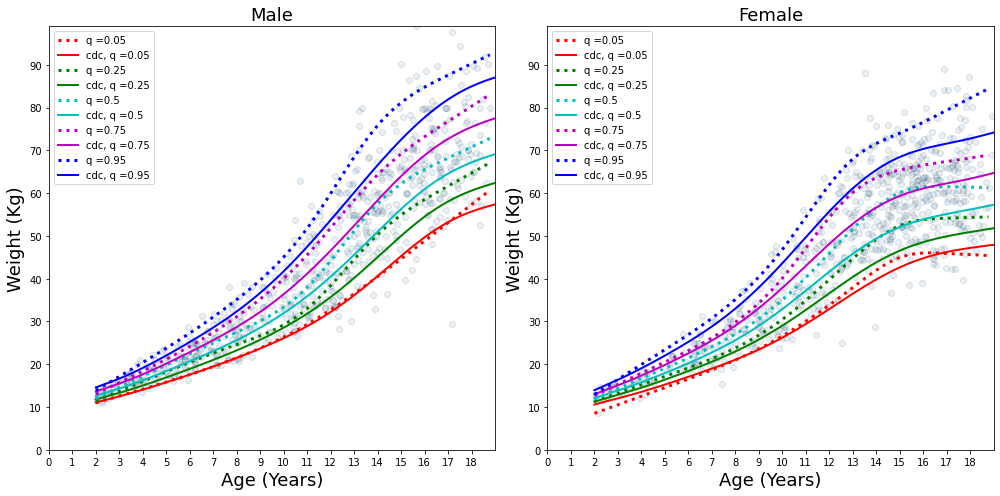

In [70]:
# Plot the results
print('Population comparison to cdc data on ' + response + ' using quantile regression')

cdc_df = cdc_df[cdc_df['Age']>=2]

plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           cdc_df = cdc_df,
           response=response)

In [71]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/statage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]
# infants to 3 years
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/lenageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='HEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Population comparison to cdc data on HEIGHT using quantile regression
xstart:  0
ystart:  60
xstart:  0
ystart:  60


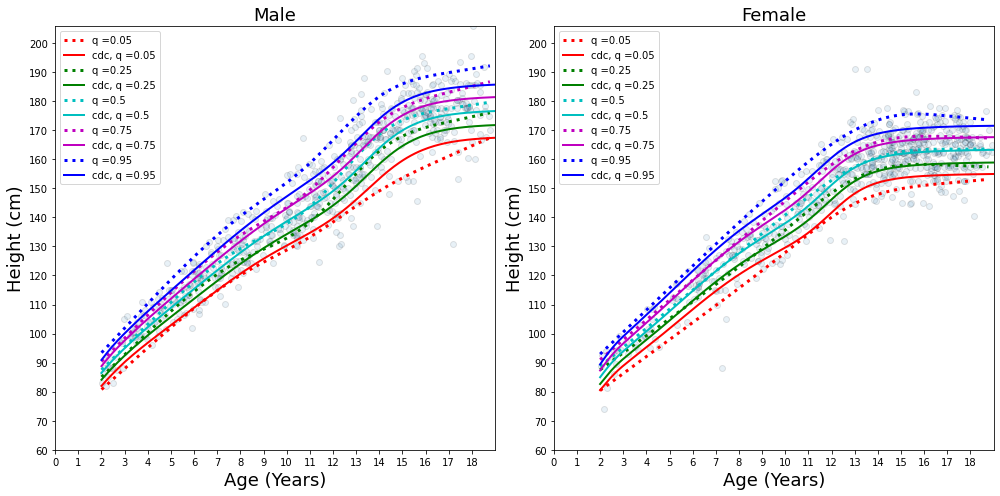

In [72]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    cdc_df = cdc_df[cdc_df['Age']>=2]
    
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response, ystart=60)

In [73]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/bmiage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

response='BMI_CALC'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Population comparison to cdc data on BMI_CALC using quantile regression
xstart:  0
ystart:  10
xstart:  0
ystart:  10


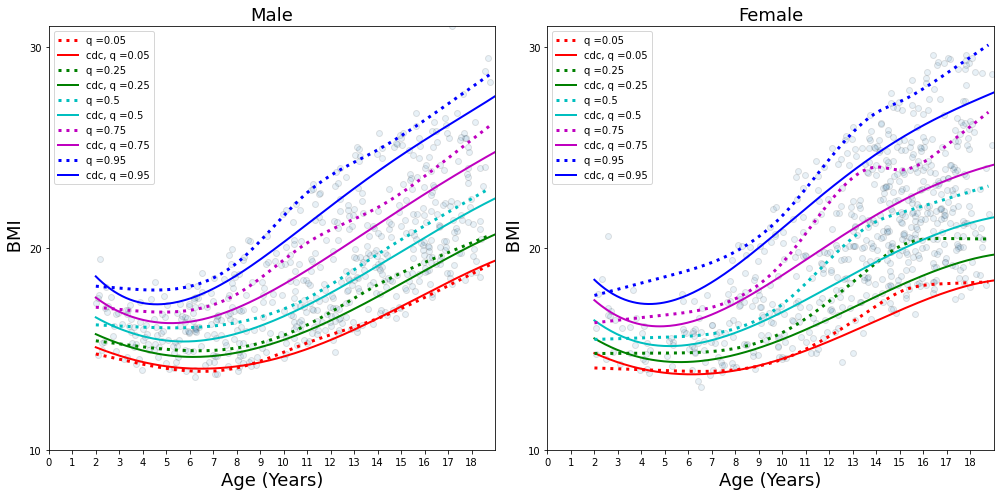

In [74]:
# Plot the results
if cdc_df is not None:
    cdc_df = cdc_df[cdc_df['Age']>=2]
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response, ystart=10)

In [75]:
response='area_cm2'

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m, response)
model_f,knots_f = spline_model_optimizer_cr(df_f, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [160]:
knots_m

[3.0, 8.0, 11.5, 14.0, 17.0]

In [161]:
knots_f

[5.0, 10.0, 13.0, 15.0, 17.0]

Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)
Total outliers:  69 Total points:  660
xstart:  0
ystart:  0
Total outliers:  74 Total points:  691
xstart:  0
ystart:  0


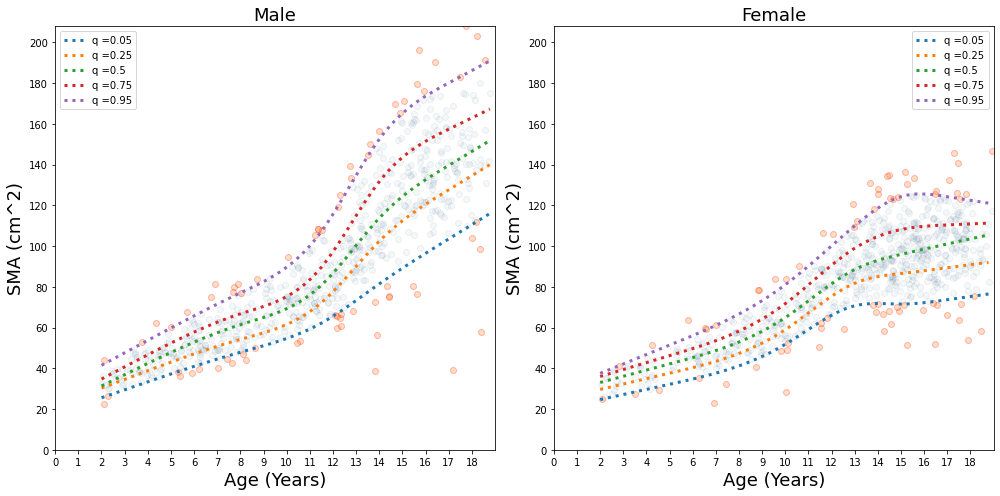

In [76]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)')
results_df = plot_bs_qr_cr([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)
results_df.to_csv(os.path.join(output,'age_sma_table.csv'))

In [77]:
response='smi'

df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

In [78]:
knots_m

[3.0, 8.0, 11.0, 14.0, 17.0]

In [79]:
knots_f

[5.0, 10.0, 13.0, 15.0, 17.0]

Quantile Regression with Splines for SMI [CCHMC data]
Total outliers:  70 Total points:  654
xstart:  0
ystart:  0
Total outliers:  75 Total points:  683
xstart:  0
ystart:  0


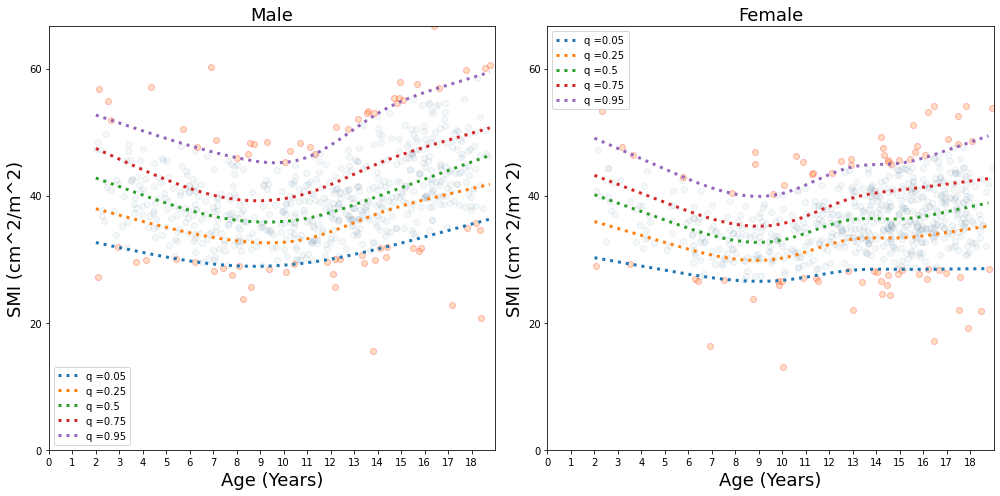

In [80]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data]')
results_df = plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)
results_df.to_csv(os.path.join(output,'age_smi_table.csv'))

In [81]:
response='area_cm2'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMA [CCHMC data] vs Weight
Total outliers:  70 Total points:  641
xstart:  10
ystart:  0
Total outliers:  72 Total points:  681
xstart:  10
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,10.951748,9.532279,11.841520,13.787975,12.708110,10.198541,14.288957,15.717248,18.949142,17.651579
1,2.5,11.775621,10.521746,12.852742,14.847089,13.988758,10.900825,15.016220,16.488792,19.734712,18.643352
2,3.0,12.599494,11.511214,13.863964,15.906204,15.269406,11.603110,15.743484,17.260336,20.520283,19.635125
3,3.5,13.423366,12.500681,14.875186,16.965318,16.550054,12.305395,16.470747,18.031880,21.305853,20.626898
4,4.0,14.247239,13.490149,15.886408,18.024433,17.830703,13.007680,17.198010,18.803424,22.091423,21.618672
5,4.5,15.071112,14.479616,16.897631,19.083547,19.111351,13.709965,17.925273,19.574968,22.876993,22.610445
6,5.0,15.894985,15.469084,17.908853,20.142662,20.391999,14.412250,18.652536,20.346513,23.662564,23.602218
7,5.5,16.718858,16.458551,18.920075,21.201776,21.672647,15.114535,19.379799,21.118057,24.448134,24.593991
8,6.0,17.542731,17.448018,19.931297,22.260891,22.953296,15.816820,20.107063,21.889601,25.233704,25.585764
9,6.5,18.366604,18.437486,20.942519,23.320005,24.233944,16.519105,20.834326,22.661145,26.019274,26.577537


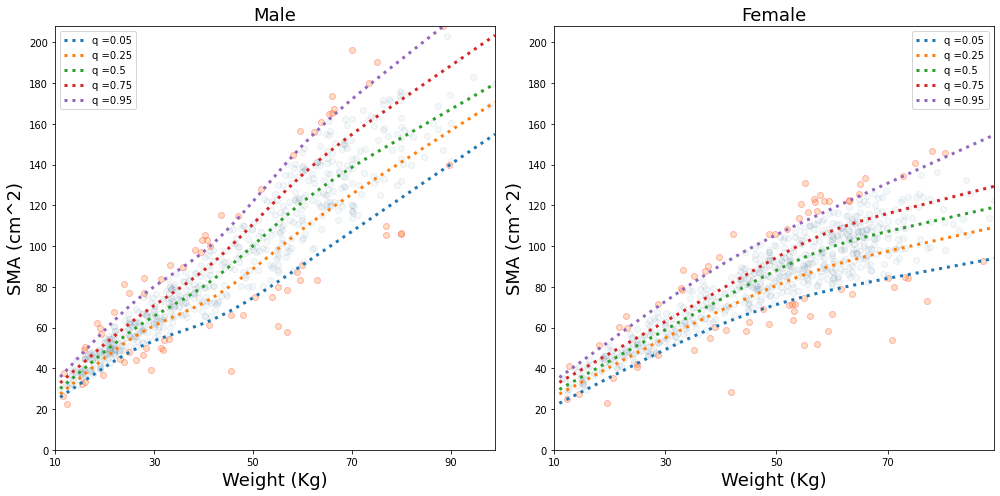

In [82]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor,xstart=10)

In [83]:
response='smi'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMI [CCHMC data] vs Weight
Total outliers:  66 Total points:  639
xstart:  10
ystart:  0
Total outliers:  72 Total points:  678
xstart:  10
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,32.597071,39.155153,43.611169,46.108649,56.481511,27.899195,34.553255,38.769280,44.169496,51.783892
1,2.5,32.526432,39.032460,43.463661,45.990035,56.281149,27.882254,34.473618,38.662659,44.004033,51.590613
2,3.0,32.455793,38.909767,43.316152,45.871420,56.080787,27.865312,34.393981,38.556037,43.838570,51.397334
3,3.5,32.385154,38.787074,43.168643,45.752806,55.880426,27.848371,34.314344,38.449415,43.673107,51.204055
4,4.0,32.314515,38.664382,43.021134,45.634191,55.680064,27.831429,34.234707,38.342793,43.507644,51.010776
5,4.5,32.243876,38.541689,42.873626,45.515577,55.479702,27.814488,34.155070,38.236171,43.342181,50.817496
6,5.0,32.173237,38.418996,42.726117,45.396962,55.279340,27.797546,34.075432,38.129550,43.176718,50.624217
7,5.5,32.102598,38.296303,42.578608,45.278348,55.078978,27.780605,33.995795,38.022928,43.011255,50.430938
8,6.0,32.031959,38.173610,42.431099,45.159734,54.878617,27.763664,33.916158,37.916306,42.845792,50.237659
9,6.5,31.961320,38.050917,42.283591,45.041119,54.678255,27.746722,33.836521,37.809684,42.680328,50.044380


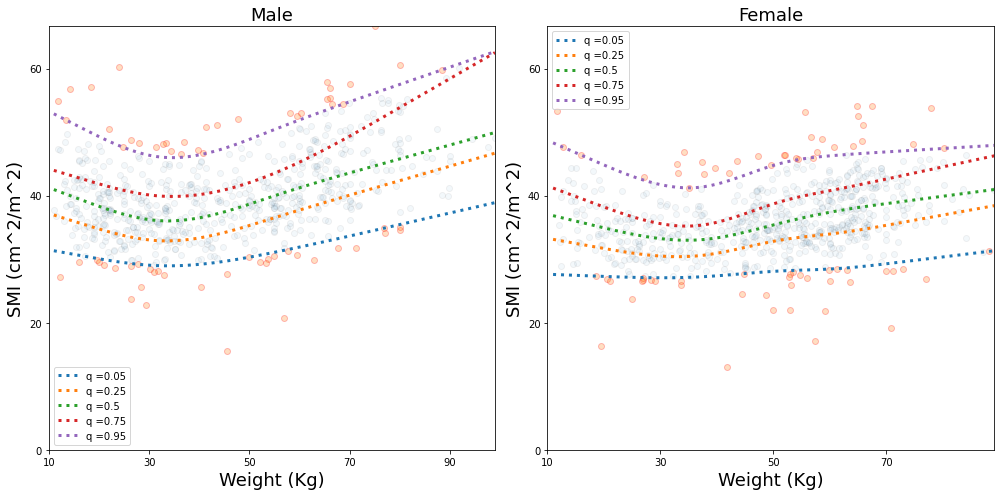

In [84]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart = 10)

In [87]:
response='area_cm2'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT
Total outliers:  69 Total points:  654
xstart:  80
ystart:  0
Total outliers:  72 Total points:  683
xstart:  80
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,-18.564967,-23.695822,-26.658437,-24.449081,-29.423265,-21.137741,-13.508170,-16.359228,-11.168164,-14.821195
1,2.5,-18.307474,-23.387417,-26.314187,-24.096819,-29.008252,-20.881849,-13.263518,-16.084452,-10.899028,-14.505623
2,3.0,-18.049981,-23.079012,-25.969938,-23.744557,-28.593239,-20.625956,-13.018867,-15.809677,-10.629891,-14.190050
3,3.5,-17.792488,-22.770607,-25.625688,-23.392295,-28.178226,-20.370063,-12.774215,-15.534901,-10.360754,-13.874477
4,4.0,-17.534995,-22.462202,-25.281438,-23.040032,-27.763213,-20.114170,-12.529564,-15.260126,-10.091618,-13.558904
5,4.5,-17.277502,-22.153796,-24.937189,-22.687770,-27.348201,-19.858277,-12.284912,-14.985351,-9.822481,-13.243332
6,5.0,-17.020008,-21.845391,-24.592939,-22.335508,-26.933188,-19.602384,-12.040261,-14.710575,-9.553344,-12.927759
7,5.5,-16.762515,-21.536986,-24.248690,-21.983246,-26.518175,-19.346492,-11.795609,-14.435800,-9.284208,-12.612186
8,6.0,-16.505022,-21.228581,-23.904440,-21.630983,-26.103162,-19.090599,-11.550958,-14.161025,-9.015071,-12.296614
9,6.5,-16.247529,-20.920175,-23.560191,-21.278721,-25.688149,-18.834706,-11.306306,-13.886249,-8.745935,-11.981041


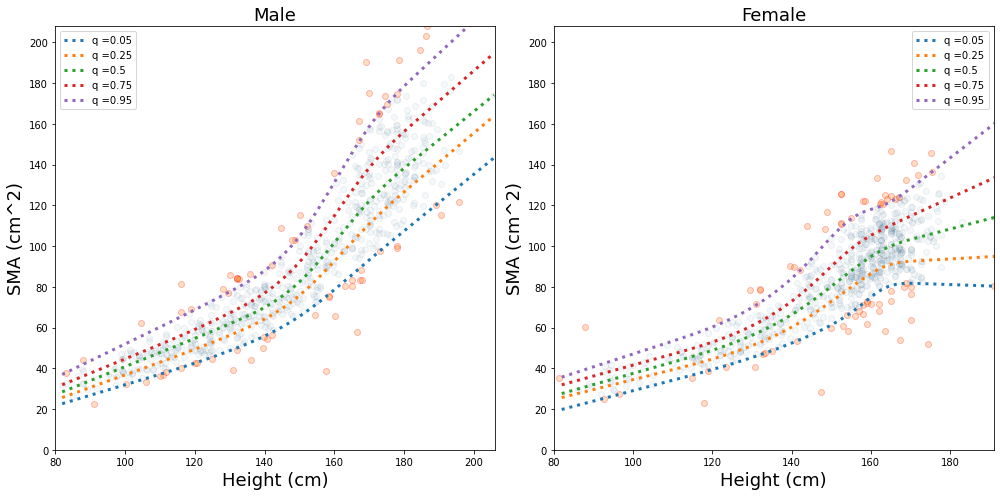

In [88]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response,predictor=predictor, xstart=80)

In [89]:
response='smi'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT
Total outliers:  69 Total points:  654
xstart:  80
ystart:  0
Total outliers:  74 Total points:  683
xstart:  80
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,44.308547,50.832455,54.587398,61.967616,71.312937,37.131601,49.686803,54.277859,64.117314,75.174550
1,2.5,44.245262,50.761493,54.515724,61.877366,71.211517,37.089829,49.608034,54.191825,64.001471,75.036668
2,3.0,44.181977,50.690530,54.444051,61.787116,71.110097,37.048058,49.529265,54.105791,63.885627,74.898785
3,3.5,44.118692,50.619568,54.372378,61.696865,71.008676,37.006286,49.450496,54.019758,63.769784,74.760903
4,4.0,44.055406,50.548606,54.300705,61.606615,70.907256,36.964514,49.371727,53.933724,63.653940,74.623021
5,4.5,43.992121,50.477644,54.229031,61.516365,70.805836,36.922743,49.292957,53.847690,63.538097,74.485138
6,5.0,43.928836,50.406682,54.157358,61.426115,70.704416,36.880971,49.214188,53.761657,63.422253,74.347256
7,5.5,43.865551,50.335720,54.085685,61.335865,70.602996,36.839199,49.135419,53.675623,63.306410,74.209374
8,6.0,43.802266,50.264757,54.014012,61.245614,70.501576,36.797428,49.056650,53.589589,63.190567,74.071491
9,6.5,43.738981,50.193795,53.942339,61.155364,70.400156,36.755656,48.977881,53.503556,63.074723,73.933609


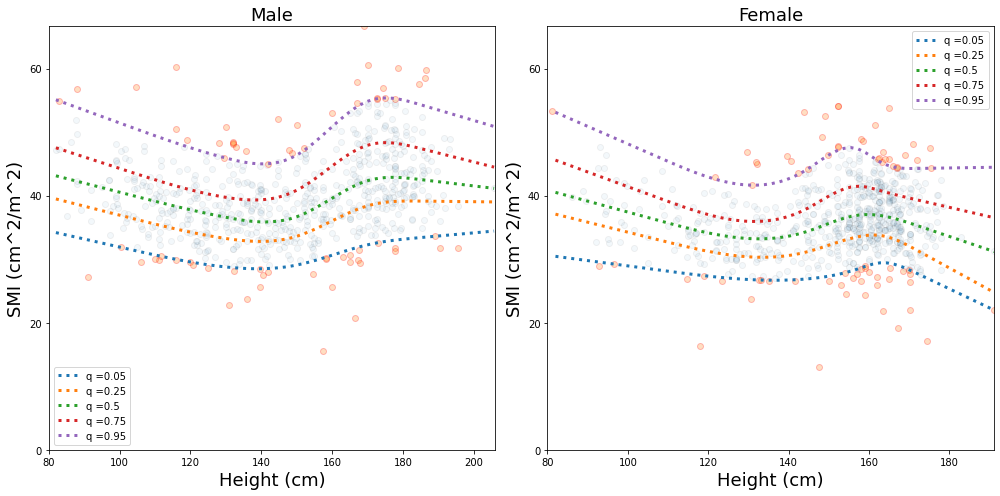

In [90]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor, xstart=80)

In [91]:
response='area_cm2'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile
Total outliers:  68 Total points:  660
xstart:  0
ystart:  0
Total outliers:  72 Total points:  691
xstart:  0
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,29.558508,42.065450,69.054325,100.638383,122.615117,18.849632,37.823220,59.074695,84.569823,97.545903
1,2.5,29.694065,42.424930,69.347810,100.989225,123.147683,19.214163,38.245749,59.365567,84.667854,97.740078
2,3.0,29.829621,42.784410,69.641296,101.340067,123.680249,19.578693,38.668278,59.656439,84.765886,97.934253
3,3.5,29.965178,43.143891,69.934782,101.690909,124.212815,19.943224,39.090806,59.947311,84.863917,98.128429
4,4.0,30.100735,43.503371,70.228268,102.041751,124.745380,20.307755,39.513335,60.238183,84.961948,98.322604
5,4.5,30.236292,43.862851,70.521753,102.392592,125.277946,20.672285,39.935864,60.529055,85.059979,98.516779
6,5.0,30.371849,44.222332,70.815239,102.743434,125.810512,21.036816,40.358393,60.819927,85.158010,98.710954
7,5.5,30.507406,44.581812,71.108725,103.094276,126.343078,21.401346,40.780922,61.110799,85.256041,98.905130
8,6.0,30.642963,44.941292,71.402211,103.445118,126.875644,21.765877,41.203451,61.401671,85.354072,99.099305
9,6.5,30.778520,45.300772,71.695697,103.795960,127.408209,22.130408,41.625980,61.692543,85.452103,99.293480


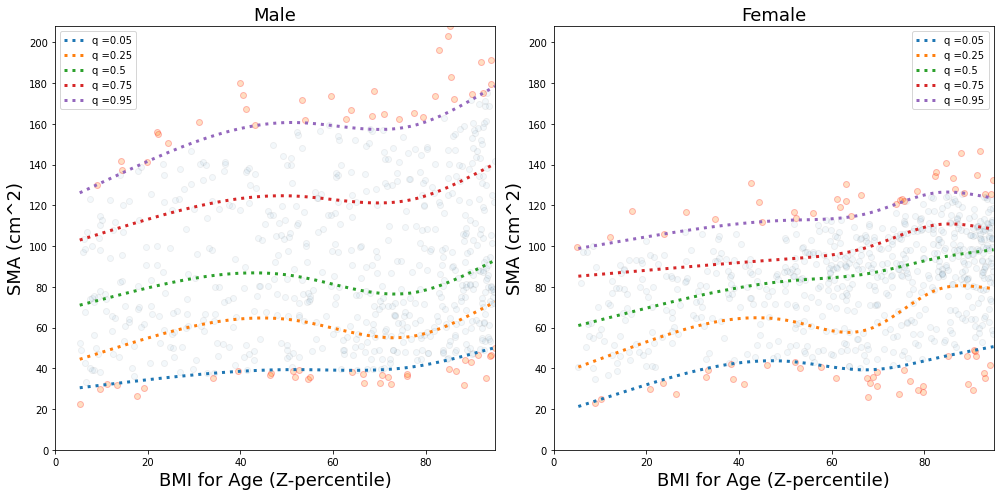

In [94]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor)

In [95]:
response='smi'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

In [96]:
knots_f

[21.200000000000003, 68.0, 92.0]

Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile
Total outliers:  68 Total points:  654
xstart:  0
ystart:  10
Total outliers:  70 Total points:  683
xstart:  0
ystart:  10


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,27.679424,31.484562,34.662639,37.508677,42.305322,25.733472,29.014394,31.925035,34.152922,42.385605
1,2.5,27.716218,31.533538,34.711514,37.569382,42.383601,25.757480,29.038548,31.954252,34.186424,42.375679
2,3.0,27.753011,31.582513,34.760388,37.630086,42.461879,25.781488,29.062703,31.983469,34.219925,42.365754
3,3.5,27.789805,31.631488,34.809263,37.690790,42.540158,25.805496,29.086858,32.012687,34.253427,42.355829
4,4.0,27.826599,31.680464,34.858138,37.751494,42.618436,25.829504,29.111013,32.041904,34.286929,42.345904
5,4.5,27.863392,31.729439,34.907013,37.812199,42.696715,25.853512,29.135167,32.071121,34.320430,42.335978
6,5.0,27.900186,31.778415,34.955887,37.872903,42.774993,25.877520,29.159322,32.100338,34.353932,42.326053
7,5.5,27.936980,31.827390,35.004762,37.933607,42.853272,25.901527,29.183477,32.129556,34.387434,42.316128
8,6.0,27.973773,31.876365,35.053637,37.994312,42.931550,25.925535,29.207632,32.158773,34.420935,42.306203
9,6.5,28.010567,31.925341,35.102512,38.055016,43.009829,25.949543,29.231786,32.187990,34.454437,42.296277


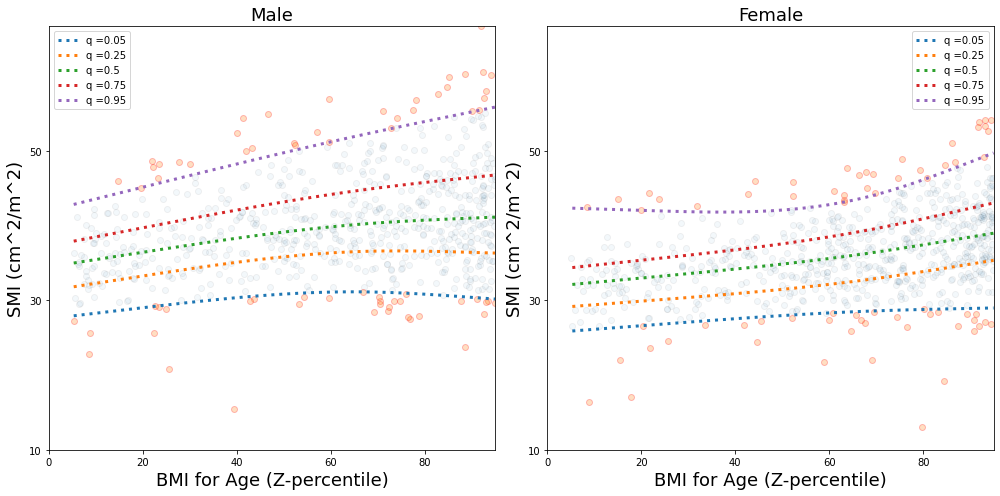

In [97]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, ystart = 10)

In [98]:
response='area_cm2'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m, qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f, qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  59 Total points:  569
xstart:  12
ystart:  0
Total outliers:  66 Total points:  631
xstart:  12
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,34.197888,32.583880,16.326514,-4.923690,-86.034665,-59.589160,-61.343153,-62.423924,-68.278389,-56.568476
1,2.5,34.110681,32.974947,17.613421,-2.486163,-79.792029,-56.211154,-57.386569,-58.101239,-63.435875,-51.660316
2,3.0,34.023475,33.366015,18.900328,-0.048635,-73.549394,-52.833147,-53.429985,-53.778555,-58.593360,-46.752155
3,3.5,33.936268,33.757082,20.187235,2.388892,-67.306758,-49.455140,-49.473401,-49.455870,-53.750845,-41.843995
4,4.0,33.849061,34.148149,21.474142,4.826419,-61.064123,-46.077133,-45.516817,-45.133185,-48.908330,-36.935834
5,4.5,33.761854,34.539217,22.761049,7.263947,-54.821487,-42.699127,-41.560233,-40.810501,-44.065815,-32.027674
6,5.0,33.674647,34.930284,24.047956,9.701474,-48.578851,-39.321120,-37.603649,-36.487816,-39.223300,-27.119513
7,5.5,33.587441,35.321352,25.334864,12.139001,-42.336216,-35.943113,-33.647065,-32.165131,-34.380785,-22.211353
8,6.0,33.500234,35.712419,26.621771,14.576529,-36.093580,-32.565106,-29.690481,-27.842447,-29.538270,-17.303192
9,6.5,33.413027,36.103487,27.908678,17.014056,-29.850945,-29.187100,-25.733897,-23.519762,-24.695756,-12.395032


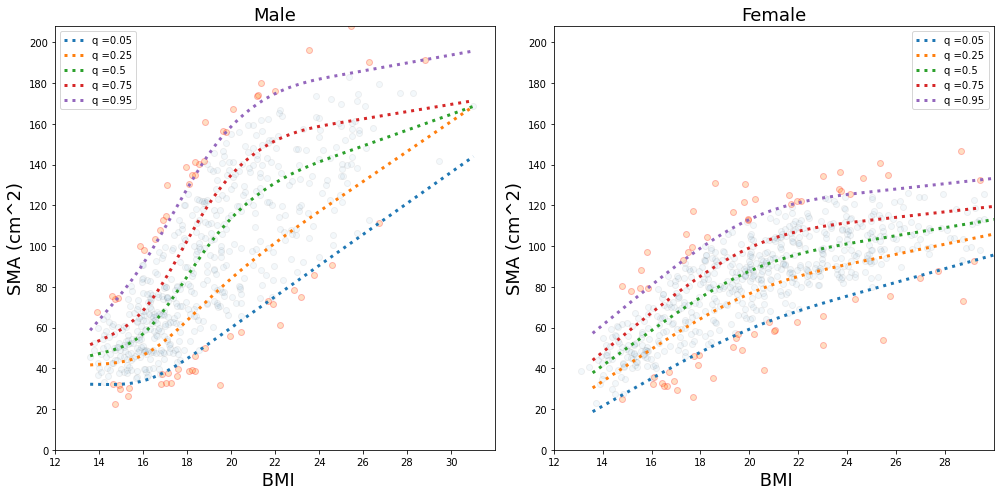

In [99]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart=12)

In [100]:
response='smi'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  62 Total points:  564
xstart:  12
ystart:  10
Total outliers:  66 Total points:  624
xstart:  12
ystart:  10


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,-0.172235,7.520515,2.719849,-4.197374,-12.984613,-1.391540,13.162602,13.773849,17.292915,32.283205
1,2.5,0.925398,8.489208,3.975499,-2.547834,-10.837241,-0.328792,13.799356,14.499963,17.990838,32.662045
2,3.0,2.023031,9.457900,5.231149,-0.898295,-8.689868,0.733957,14.436111,15.226077,18.688761,33.040885
3,3.5,3.120663,10.426593,6.486800,0.751245,-6.542495,1.796705,15.072865,15.952192,19.386684,33.419725
4,4.0,4.218296,11.395285,7.742450,2.400785,-4.395123,2.859454,15.709620,16.678306,20.084606,33.798565
5,4.5,5.315929,12.363978,8.998101,4.050325,-2.247750,3.922202,16.346374,17.404420,20.782529,34.177405
6,5.0,6.413561,13.332671,10.253751,5.699865,-0.100377,4.984951,16.983129,18.130535,21.480452,34.556245
7,5.5,7.511194,14.301363,11.509401,7.349405,2.046995,6.047699,17.619883,18.856649,22.178375,34.935085
8,6.0,8.608827,15.270056,12.765052,8.998944,4.194368,7.110448,18.256638,19.582763,22.876298,35.313925
9,6.5,9.706459,16.238748,14.020702,10.648484,6.341741,8.173196,18.893392,20.308878,23.574220,35.692765


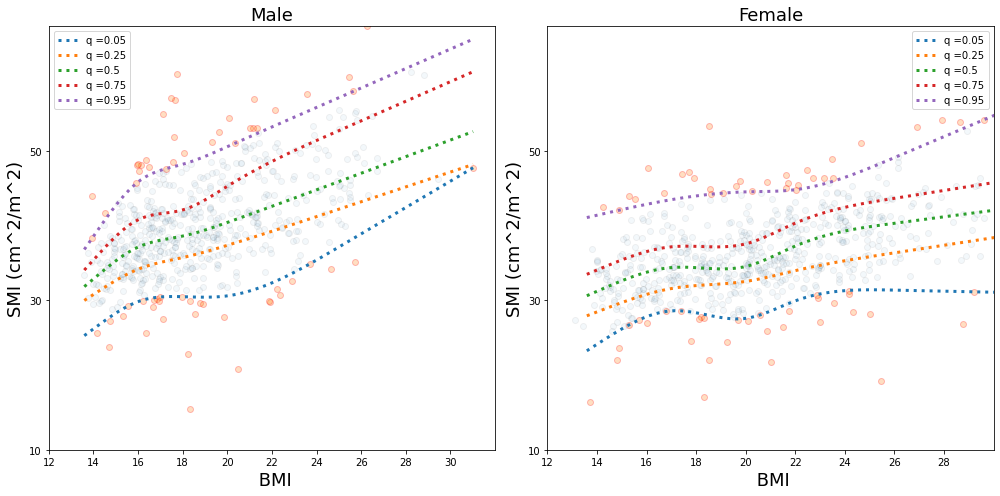

In [101]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response,predictor=predictor, xstart=12, ystart=10)